<a href="https://colab.research.google.com/github/fru2/image_classification_TF/blob/master/image_classification_GCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Classification using tensorflow 2.0.

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds
from PIL import Image

import requests
from io import BytesIO

DIRECTORY NAME AND IMAGE NAME

In [0]:
testImage = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQHC8nbGhZ_6oMbDpCisGdtaDHHVU9dq6MmSP9AmU7giZN1VcKL'
response = requests.get(testImage)
image = Image.open(BytesIO(response.content))

data = np.ndarray(shape=(1, 128, 128, 3), dtype=np.float32)

image = image.resize((128, 128))
image_array = np.asarray(image)
normalized_image_array = image_array / 255.0
data[0] = normalized_image_array


####################################
offineFoderScan = False            #    select True if wanna scan the whole folder for prediction
directory = '/myFiles'             #    for offline use case only
fileType = ".jpg"                  #
####################################

In [0]:
def importImage(modelName, graphName):
  for file in os.listdir(directory):
    if file.endswith(fileType):
      fullPath = os.path.join(directory, file)

      image = Image.open(fullPath)

      plt.imshow(image)

      image = image.resize((128, 128))
      image_array = np.asarray(image)
      normalized_image_array = image_array / 255.0
      data[0] = normalized_image_array

      prediction = modelName.predict(data)

      print()
      print("###########################################")
      print("Prediction by " + graphName)
      print(prediction)
      print("###########################################")
      print()


In [0]:
if (int(tf.__version__[0]) < 2):
  !pip install tensorflow==2.0

keras = tf.keras

In [0]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load('horses_or_humans', split=list(splits), with_info=True, as_supervised=True)


In [0]:
"""get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(20):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))"""

"get_label_name = metadata.features['label'].int2str\nfor image, label in raw_train.take(20):\n  plt.figure()\n  plt.imshow(image)\n  plt.title(get_label_name(label))"

In [0]:
IMG_SIZE = 128

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [0]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 128, 128, 3])

LOADING AND TRAINING PRE-TRAINED MODEL

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

first_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

second_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')


In [0]:
def modelSet(model_name, graphName):
  feature_batch = model_name(image_batch)
  # print(feature_batch.shape)

  model_name.trainable = False
  #model_name.summary()

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  feature_batch_average = global_average_layer(feature_batch)
  # print(feature_batch_average.shape)

  prediction_layer = keras.layers.Dense(1)
  prediction_batch = prediction_layer(feature_batch_average)
  # print(prediction_batch.shape)
  # print()

  model = tf.keras.Sequential([
    model_name,
    global_average_layer,
    prediction_layer
  ])

  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  # model.summary()
  # len(model.trainable_variables)

  num_train, num_val, num_test = (
    metadata.splits['train'].num_examples*weight/10
    for weight in SPLIT_WEIGHTS
  )

  initial_epochs = 10
  steps_per_epoch = round(num_train)//BATCH_SIZE
  validation_steps = 4

  loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

  print("initial loss: {:.2f}".format(loss0))
  print("initial accuracy: {:.2f}".format(accuracy0))

  history = model.fit(train_batches,
                      epochs=initial_epochs,
                      validation_data=validation_batches)
  
  plotGraph(history, graphName)
  
  if (offineFoderScan):
    importImage(model)

  else:
    samplePrediction = model.predict(data)

    image.show()

    print()
    print("###########################################")
    print("Prediction by " + graphName)
    print(samplePrediction)
    print("###########################################")
    print()

In [0]:
def customModel(graphName):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(2, activation='softmax'))


  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  history = model.fit(train_batches,
                      epochs=10,
                      validation_data=validation_batches)
  
  plotGraph(history, "My Custom Model")

  if (offineFoderScan):
    importImage(model)

  else:

    samplePrediction = model.predict(data)

    image.show()

    print()
    print("###########################################")
    print("Prediction by " + graphName)
    print(samplePrediction)
    print("###########################################")
    print()

In [0]:
def plotGraph(data, graphName):
  acc = data.history['accuracy']
  val_acc = data.history['val_accuracy']

  loss = data.history['loss']
  val_loss = data.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy by ' + graphName)

4/4 [==============================] - 4s 913ms/step - loss: 4.8200 - accuracy: 0.5900
initial loss: 4.82
initial accuracy: 0.59
Epoch 1/10
26/26 [==============================] - 38s 1s/step - loss: 4.1305 - accuracy: 0.5913 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
26/26 [==============================] - 34s 1s/step - loss: 3.4062 - accuracy: 0.6336 - val_loss: 2.0636 - val_accuracy: 0.7900
Epoch 3/10
26/26 [==============================] - 34s 1s/step - loss: 3.0457 - accuracy: 0.6663 - val_loss: 0.9072 - val_accuracy: 0.8300
Epoch 4/10
26/26 [==============================] - 34s 1s/step - loss: 2.5649 - accuracy: 0.7122 - val_loss: 0.6513 - val_accuracy: 0.8900
Epoch 5/10
26/26 [==============================] - 34s 1s/step - loss: 2.2119 - accuracy: 0.7146 - val_loss: 0.4856 - val_accuracy: 0.9100
Epoch 6/10
26/26 [==============================] - 34s 1s/step - loss: 2.2305 - accuracy: 0.7304 - val_loss: 0.3894 - val_accuracy: 0.9100
Epoch 7/10
26/26 [=====

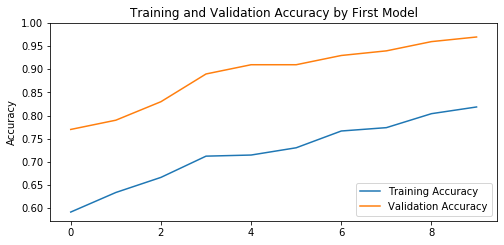

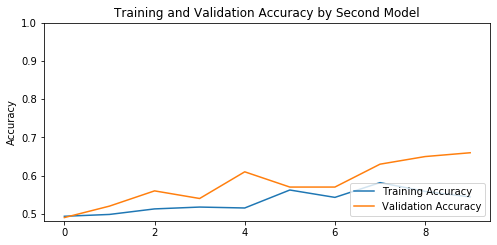

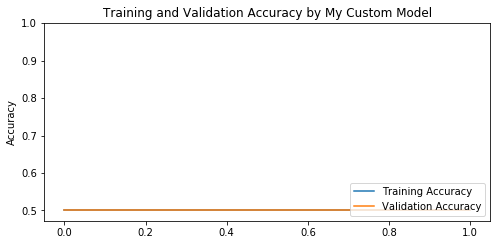

In [0]:
modelSet(first_model, "First Model")
modelSet(second_model, "Second Model")
customModel("My Custom Model")